<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

# Импорт данных + Тех. анализ

In [1]:
#!pip install apimoex

In [1]:
import requests
import numpy as np
import apimoex
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import talib as ta

In [2]:
list(ta.get_function_groups().keys()) #возможные функции библиотеки для тех. анализа 

['Cycle Indicators',
 'Math Operators',
 'Math Transform',
 'Momentum Indicators',
 'Overlap Studies',
 'Pattern Recognition',
 'Price Transform',
 'Statistic Functions',
 'Volatility Indicators',
 'Volume Indicators']

In [16]:
stock_quotes = ['GAZP', 'YNDX', 'RUAL', 'IRAO', 'GMKN', 'LKOH', 'MGNT', 'MTSS', 'NVTK', 'PLZL', 'ROSN', 'SBER',
               'SNGS', 'TATN','CHMF']

In [17]:
# with requests.Session() as session:
#     for elem in stock_quotes:
#         data = apimoex.get_board_history(session, elem)
#         df_2 = pd.DataFrame(data)
#         df_2.rename(columns = {'CLOSE':elem}, inplace = True)
#         print(elem, df_2['TRADEDATE'][0])

In [107]:
df = pd.DataFrame({"begin": pd.date_range(start='2015-03-30', freq='1d', end=date.today()- timedelta(days=1))})

In [108]:
df.head(3)

,begin
0,2015-03-30
1,2015-03-31
2,2015-04-01


In [109]:
with requests.Session() as session:
    for elem in stock_quotes:
        data = apimoex.get_market_candles(session, elem, interval = 24, columns = ('begin', 'open', 'close', 'high', 'low'),
                                          start = '2015-03-30', end = date.today() - timedelta(days=1)) #задаём нужные параметры
        data = pd.DataFrame(data)
        data.rename(columns = {'open':'open_'+elem, 'close': 'close_'+elem, 'high': 'high_'+elem, 'low': 'low_'+elem}, inplace = True)
        
        #немного переименовал колонки, чтобы было удобнее
        data['begin'] = data['begin'].apply(lambda x: x[:11]) #берём только нужные элементы даты, без часов, минут и т.д.
        data['begin'] = pd.to_datetime(data['begin']) #переводим в нужный формат
        df = pd.merge(df, data, on='begin', how='inner')
    
for elem in stock_quotes:
    #расчёт индикаторов тех. анализа  (Осциляторы)
    df['RSI_'+elem] = ta.RSI(df['close_'+elem]) #расчитали первый технический индикатор (RSI)
        
    slowk, slowd = ta.STOCH(df['high_'+elem], df['low_'+elem], df['close_'+elem]) #расчитали первый технический индикатор (STOCHASTIC)
    df['STOCH_slowk'+elem] = slowk
    df['STOCH_slowd'+elem] = slowd
        
    macd, macdsignal, macdhist = ta.MACD(df['close_'+elem])
    df['MACD_'+elem] = macd
    df['MACDSIGNAL_'+elem] = macdsignal
    df['MACDHIST_'+elem] = macdhist
#----------------------------------------------------------------------------------------    
    #Расчёт SMA, EMA, Bollinger
    df['SMA_'+elem] = ta.SMA(df['close_'+elem]) #Рассчитали простую скользящую среднюю 
    df['EMA_'+elem] = ta.EMA(df['close_'+elem]) #Рассчитали экспоненциальную скользящую среднюю
    
    upperband, middleband, lowerband = ta.BBANDS(df['close_'+elem]) #Рассчитали полосы боллиндежра
    df['BOLLINGER_up_'+elem] = upperband
    df['BOOLLINGER_low_'+elem] = lowerband
    df['BOOLLINGER_mid_'+elem] = middleband
#-----------------------------------------------------------------------------------------------------------   
    #Анализируем наличие свечных паттернов
    threeLineStrike = ta.CDL3LINESTRIKE(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])
    df['3_Line_Strike_'+elem] = threeLineStrike
    
    eveningStar = ta.CDLEVENINGSTAR(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])#вечерняя звезда
    df['Evening_Star_'+elem] = eveningStar 
    
    hammer = ta.CDLHAMMER(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])
    df['Hammer_'+elem] = hammer 
    
    morningStar = ta.CDLMORNINGSTAR(df['open_'+elem],df['high_'+elem],df['low_'+elem],df['close_'+elem])
    df['Morning_Star_'+elem] = morningStar 

#----------------------------------------------------------------------------------------------------------
#Вроде, весб тех. анализ импортнул 

C:\Users\CD86~1\AppData\Local\Temp/ipykernel_12960/3960893911.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\CD86~1\AppData\Local\Temp/ipykernel_12960/3960893911.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\CD86~1\AppData\Local\Temp/ipykernel_12960/3960893911.py:37: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragm

In [110]:
df

,begin,open_GAZP,close_GAZP,high_GAZP,low_GAZP,open_YNDX,close_YNDX,high_YNDX,low_YNDX,open_RUAL,...,MACDHIST_CHMF,SMA_CHMF,EMA_CHMF,BOLLINGER_up_CHMF,BOOLLINGER_low_CHMF,BOOLLINGER_mid_CHMF,3_Line_Strike_CHMF,Evening_Star_CHMF,Hammer_CHMF,Morning_Star_CHMF
0,2015-03-30,134.50,137.00,137.88,134.24,877.0,887.0,903.0,877.0,37.000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
1,2015-03-31,136.85,138.90,139.19,136.60,891.0,893.0,895.0,878.0,36.850,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,2015-04-01,138.45,143.00,143.20,137.57,885.0,902.0,903.0,883.0,36.000,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
3,2015-04-02,143.83,143.90,144.88,142.32,902.0,919.0,920.0,887.0,36.005,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,2015-04-03,144.00,143.94,145.65,143.02,924.0,940.0,946.0,922.0,36.000,...,NaN,NaN,NaN,663.243602,634.176398,648.71,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169,2023-12-04,162.48,160.01,162.48,159.81,2420.0,2397.8,2436.8,2365.6,36.900,...,-7.951831,1345.086667,1331.852896,1315.736266,1244.503734,1280.12,0,0,0,0
2170,2023-12-05,160.17,160.46,161.44,159.10,2419.8,2418.6,2433.0,2385.0,35.900,...,-5.381349,1341.753333,1329.488193,1309.522667,1247.117333,1278.32,0,0,0,0
2171,2023-12-06,160.73,158.74,161.41,158.50,2420.2,2320.6,2428.8,2301.0,36.420,...,-6.077070,1337.240000,1324.488955,1299.541368,1239.018632,1269.28,0,0,0,0
2172,2023-12-07,158.80,163.38,164.77,157.26,2327.0,2349.8,2367.6,2296.2,35.580,...,-6.459462,1333.086667,1319.360635,1300.699861,1228.580139,1264.64,0,0,0,0


In [111]:
df.isna().sum()#Пропуски должны быть, не нужно их удалять. Индикаторам нужны первые дни, чтобы хоть что-то расчитать 

begin                  0
open_GAZP              0
close_GAZP             0
high_GAZP              0
low_GAZP               0
                      ..
BOOLLINGER_mid_CHMF    4
3_Line_Strike_CHMF     0
Evening_Star_CHMF      0
Hammer_CHMF            0
Morning_Star_CHMF      0
Length: 286, dtype: int64

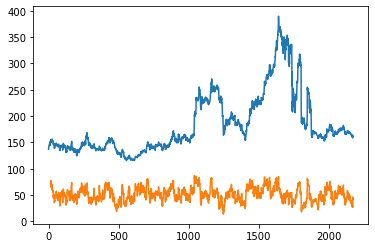

In [112]:
plt.plot(list(df['close_GAZP']))
plt.plot(list(df['RSI_GAZP']))
#Нужно явно что-то красивее matplotlib-а. Нижний график должен быть с отдельной осью, чуть меньше и ниже основного графика

In [33]:
df.to_csv("fin_quotes_per_day.csv", index=False)

# Свечные паттерны 

In [82]:
#пока не работает, ручно паттерн
# def detect_head_shoulder(df, window=3):
# # Define the rolling window
#     for elem in stock_quotes:
#         roll_window = window
#         # Create a rolling window for High and Low
#         df['high_roll_max_'+elem] = df['high_'+elem].rolling(window=roll_window).max()
#         df['low_roll_min_'+elem] = df['low_'+elem].rolling(window=roll_window).min()
#         # Create a boolean mask for Head and Shoulder pattern
#         mask_head_shoulder = ((df['high_roll_max_'+elem] > df['high_'+elem].shift(1)) & (df['high_roll_max_'+elem] > df['high_'+elem].shift(-1)) & (df['high_'+elem] < df['high_'+elem].shift(1)) & (df['high_'+elem] < df['high_'+elem].shift(-1)))
#         # Create a boolean mask for Inverse Head and Shoulder pattern
#         mask_inv_head_shoulder = ((df['low_roll_min_'+elem] < df['low_'+elem].shift(1)) & (df['low_roll_min_'+elem] < df['low_'+elem].shift(-1)) & (df['low_'+elem] > df['low_'+elem].shift(1)) & (df['low_'+elem] > df['low_'+elem].shift(-1)))
#         # Create a new column for Head and Shoulder and its inverse pattern and populate it using the boolean masks
#         df['head_shoulder_pattern_'+elem] = np.nan
#         df.loc[mask_head_shoulder, 'head_shoulder_pattern_'+elem] = 'Head and Shoulder'
#         df.loc[mask_inv_head_shoulder, 'head_shoulder_pattern_'+elem] = 'Inverse Head and Shoulder'
#     return df

# Визуализируем  всё

In [134]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('GAZP_price', 'RSI_GAZP'), 
               row_width=[0.2, 0.7])

candle_graph = go.Candlestick( #обязательно должен выдавать такой график с ценой, без индикаторов, если пользователь ничего не указал
                            x=df['begin'],
                            open=df['open_GAZP'],
                            high=df['high_GAZP'],
                            low=df['low_GAZP'],
                            close=df['close_GAZP'])
                            # рисуем основной график 
fig.add_trace(candle_graph, row = 1, col = 1) #отрисовываем основной график

#ещё бы добавить возможность отрисовки не всех годов, а только указанны, например 5 лет, 3 года, 1 год(последний) и т.д.
#Далее, в зависимости от того, что выбрал пользователь (какие индикаторы), их нужно добавлять на график, ниже я написал код, как
#это сделать 



#Рисуем паттерны --------------------------------------------------------------------
#вставил пока довольно базовые паттерны

Line_Strike = df[df['3_Line_Strike_GAZP']!=0]
#fig.add_trace(go.Scatter(x=Line_Strike['begin'], y=Line_Strike['high_GAZP'], mode='markers', name='3_Line_Strike', 
#                         marker=dict(symbol='circle', size=10, color = 'blue')), row = 1, col = 1)

evening_Star = df[df['Evening_Star_GAZP']!=0]
#fig.add_trace(go.Scatter(x=evening_Star['begin'], y=evening_Star['high_GAZP'], mode='markers', name='evening_Star', 
#                         marker=dict(symbol='circle', size=10, color = 'yellow')), row = 1, col = 1)

hammer = df[df['Hammer_GAZP']!=0]
#fig.add_trace(go.Scatter(x=hammer['begin'], y=hammer['high_GAZP'], mode='markers', name='Hammer', 
#                         marker=dict(symbol='circle', size=10, color = 'orange')), row = 1, col = 1)

morningStar = df[df['Morning_Star_GAZP']!=0]
#fig.add_trace(go.Scatter(x=morningStar['begin'], y=morningStar['high_GAZP'], mode='markers', name='morning_Star', 
#                         marker=dict(symbol='circle', size=10, color = 'purple')), row = 1, col = 1)

#чтобы отрисовать, просто уберите # с fig.add_trace и ниже


#Тут всё Готово!!!!
#------------------------------------------------------------------------------------------

sma = go.Scatter(x=df['begin'], #отрисовываем скользящую среднюю
                 y=df["SMA_GAZP"],
                 name="SMA",
                 line=dict(color='blue')
                )

ema = go.Scatter(x=df['begin'], #отрисовываем экспоненциальную скользящую среднюю
                 y=df["EMA_GAZP"],
                 line=dict(color='yellow'),
                 name = 'EMA'
                )

#fig.add_trace(sma, row=1, col=1)
#fig.add_trace(ema, row=1, col=1) - отрисовать графики
#Тут всё Готово!!!!
#----------------------------------------------------------------------------------------------

Bollinger_up = go.Scatter(x=df['begin'], #отрисовываем верхнюю полусу боллинджера
                 y=df["BOLLINGER_up_GAZP"],
                 line=dict(color='blue'),
                 name = 'BOLLINGER_up'
                )

Bollinger_low = go.Scatter(x=df['begin'], #отрисовываем верхнюю полусу боллинджер
                 y=df["BOOLLINGER_low_GAZP"],
                 line=dict(color='blue'),
                 name = 'BOLLINGER_low'
                )

Bollinger_mid = go.Scatter(x=df['begin'], #отрисовываем серединную полусу боллинджер
                 y=df["BOOLLINGER_mid_GAZP"],
                 line=dict(color='orange'),
                 name = 'BOLLINGER_mid'
                )

#fig.add_trace(Bollinger_up, row=1, col=1) - отрисовать графики
#fig.add_trace(Bollinger_low, row=1, col=1)
#fig.add_trace(Bollinger_mid, row=1, col=1)
#Тут всё Готово!!!!
#----------------------------------------------------------------------------------------

#рисуем оссцилятор 
rsi = go.Scatter(x=df['begin'], y=df['RSI_GAZP'], line=dict(color='purple'), name='RSI')
#Отрисовать RSI:
#fig.add_trace(rsi, row = 2, col = 1)
#fig.add_hline(y=20, row = 2, col = 1, line=dict(color="gray"))
#fig.add_hline(y=80, row = 2, col = 1, line=dict(color="gray"))


macd_usual = go.Scatter(x=df['begin'], y=df['MACD_GAZP'], line=dict(color='blue'), name='MACD')
macd_signal = go.Scatter(x=df['begin'], y=df['MACDSIGNAL_GAZP'], line=dict(color='orange'), name='Signal')
#macdhist_hist = go.Histogram(x=df['begin'], y=df['MACDHIST_GAZP'], name='MACD Histogram') #это пока не работает
#Отрисовать MACD:
#fig.add_trace(macd_usual, row = 2, col = 1)
#fig.add_trace(macd_signal, row = 2, col = 1)
#fig.add_trace(macdhist_hist, row = 2, col = 1)

slowk_trace = go.Scatter(x=df['begin'], y=df['STOCH_slowkGAZP'], mode='lines', name='STOCH SlowK')
slowd_trace = go.Scatter(x=df['begin'], y=df['STOCH_slowdGAZP'], mode='lines', name='STOCH SlowD')

#fig.add_trace(slowk_trace, row=2, col=1)
#fig.add_trace(slowd_trace, row=2, col=1)
 
#Тут нужно немного доделать
#------------------------------------------------------------------------
fig.update_layout(xaxis_rangeslider_visible=False) #дополнительные штуки для отрисовки
fig.update_layout(
    width=800, height=600,
    title="GAZP 2015 - 2023",
    yaxis_title='GAZP Stock',
)

fig.show()

#сюда можно добавить ещё один график снизу, чтобы можно было просматривать два оссцилятора 

---------------------------------------------------------------